In [1]:
import random, os
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # (필요하면) torch.use_deterministic_algorithms(True)

seed_everything(42)

# [문제 1] 수업 자료에서 제시하고 있는 다음 코드들을 Backend AI 또는Google Colab 등으로 옮겨 실행하고 각 결과를 잘 정리하여 제시하기<br>
– _01_code/_18_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py<br>
• 실행 결과 제시<br>
• Wandb URL #1<br>

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

#BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl

import sys
#sys.path.append(BASE_PATH)
sys.path.append(str(BASE_PATH))

#CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset


def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  #args = parser.parse_args()
  args, _ = parser.parse_known_args()   # ✅ Jupyter 인자(--f=...) 무시
  main(args)

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb


wandb: Currently logged in as: launcher1423 (launcher1423-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 6.08589, V_loss: 12.75682, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 3.06327, V_loss: 6.24883, V_loss decreased (12.75682 --> 6.24883). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.22282, V_loss: 0.07806, V_loss decreased (6.24883 --> 0.07806). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.12929, V_loss: 0.07040, V_loss decreased (0.07806 --> 0.07040). Saving model... | T_time: 00:00:05, T_speed: 18.000
[Epoch 120] T_loss: 0.09705, V_loss: 0.04346, V_loss decreased (0.07040 --> 0.04346). Saving model... | T_time: 00:00:06

Epoch,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Validation loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3930
Training loss,0.00721
Training speed (epochs/sec.),19.07767
Validation loss,0.00415


## _01_code/_18_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py<br>
• 실행 결과 제시 & 출력 그래프 제시 (predict_all 함수 수행 결과)<br>

MODEL FILE: c:\Users\user\git\link_dl\_04_your_code\checkpoints\lstm_regression_btc_krw_checkpoint_latest.pt


C:\Users\user\AppData\Local\Temp\ipykernel_30888\3929763665.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map

[TEST DATA]
 0: 459.66 <--> 462.33 (Loss:          2.67)
 1: 403.63 <--> 405.02 (Loss:          1.39)
 2: 403.53 <--> 444.08 (Loss:         40.55)
 3: 466.43 <--> 464.58 (Loss:          1.85)
 4: 463.22 <--> 468.41 (Loss:          5.20)
 5: 401.94 <--> 404.00 (Loss:          2.06)
 6: 470.72 <--> 461.57 (Loss:          9.15)
 7: 450.08 <--> 455.68 (Loss:          5.60)
 8: 461.10 <--> 466.85 (Loss:          5.75)
 9: 464.04 <--> 459.89 (Loss:          4.15)


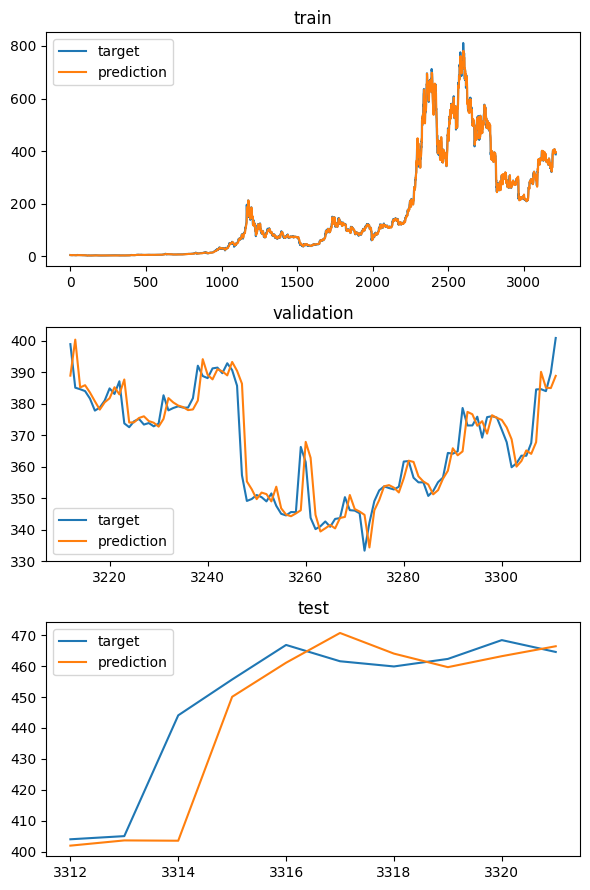

In [3]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path


#BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
#sys.path.append(BASE_PATH)
sys.path.append(str(BASE_PATH))

#CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._18_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  #args = parser.parse_args()
  args, _ = parser.parse_known_args()   # ✅ Jupyter 인자(--f=...) 무시
  main(args)


## _01_code/_18_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py<br>
• 실행 결과 제시<br>
• Wandb URL #2<br>

In [4]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

#BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

#CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._18_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  #args = parser.parse_args()
  args, _ = parser.parse_known_args()   # ✅ Jupyter 인자(--f=...) 무시
  main(args)
  # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69382, T_accuracy: 47.1980 | V_loss: 0.69326, V_accuracy: 49.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69059, T_accuracy: 53.0822 | V_loss: 0.69264, V_accuracy: 51.0000 | V_loss decreased (0.69326 --> 0.69264). Saving model... | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.68998, T_accuracy: 52.9888 | V_loss: 0.69263, V_accuracy: 51.0000 | V_loss decreased (0.69264 --> 0.69263). Saving model... | T_time: 00:00:04, T_speed: 15.000
[Epoch  90] T_loss: 0.68974, T_accuracy: 53.0511 | V_loss: 0.69260, V_accuracy: 51.0000 | V_loss decreased (0.69263 --> 0.69260)

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▅▅▅▅▅▅▅▅▅▅▆▆▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███
Training loss,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▅▃▃▃▂▂▁
Training speed (epochs/sec.),▁██████████████████████████████████
Validation accuracy (%),▄▅▅▅▅▅▅▅▅▅▅█▄▄▄▄▄▄▃▃▅▃▅▅▆▃▅▂▅▁▄▂▂▅▂
Validation loss,▂▁▁▁▁▁▁▁▁▁▁▁▂▄▃▃▃▂▂▂▂▁▁▂▂▂▂▂▃▃▄▅▆█▇
Epoch,1020
Training accuracy (%),56.72478
Training loss,0.66185
Training speed (epochs/sec.),14.16667
Validation accuracy (%),47


## _01_code/_18_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py<br>
• 실행 결과 제시<br>

In [5]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb


#BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

#CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._18_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data
from _01_code._18_lstm_and_its_application.i_crypto_currency_classification_train_lstm import get_model


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  #args = parser.parse_args()
  args, _ = parser.parse_known_args()   # ✅ Jupyter 인자(--f=...) 무시
  main(args)


MODEL FILE: c:\Users\user\git\link_dl\_04_your_code\checkpoints\lstm_classification_btc_krw_checkpoint_latest.pt


C:\Users\user\AppData\Local\Temp\ipykernel_30888\456415323.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_l

[TEST DATA]
TEST RESULTS: 80.000%
 0:   1.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   0.00 <-->   1.00
 5:   0.00 <-->   0.00
 6:   0.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   0.00 <-->   1.00


# [문제 2] 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기 (1/2) – Classification 학습을 위한 데이터 관련 설정 값
• sequence_size=21, validation_size=150, test_size=30, is_regression=True– 위 설정과 함께 Regression 및 Classification 문제를 학습할 때 다음 사항들을 적절하게 
설정하여 가장 학습이 잘 되는 모델 구성 및 하이퍼파라미터 값을 찾아 제시<br>
• LSTM layers 개수 변경<br>
• LSTM Layer 이후에 사용하는 Linear Layer 개수 변경<br>
• weight decay 값 변경<br>
Ø수업에서 제시하고 있는 실습 화일내 weight_decay값 설정 방법 참고<br>
• dropout rate 값 변경<br>
Ødropout rate 설정을 위하여<br>
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html<br>
• Wandb URL #3 (Regression)<br>
참고<br>
ØRegression 테스트 성능 비교시에는 predict_all 함수 수행 결과 그래프를 각각 제시<br>
<br>
• Wandb URL #4 (Classification)<br>


In [6]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
import numpy as np

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(BASE_PATH, "_04_your_code", "BTC_KRW_2025_11_30.csv")
  df = pd.read_csv(btc_krw_path, skiprows=[1])     # ✅ Ticker 메타행 제거
  df = df.rename(columns={'Price': 'Date'})    # ✅ 첫 컬럼이 Date 역할
  df = df[df['Date'] != 'Date'].copy()         # ✅ "Date,,,,," 라벨 행 제거
  df['Date'] = pd.to_datetime(df['Date'])      # ✅ 날짜 파싱
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )
  


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True,
                     target_column="Close", y_normalizer=1.0e7, batch_size=32):

    X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column=target_column,
        y_normalizer=y_normalizer,
        is_regression=is_regression
    )

    train_ds = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    val_ds   = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_ds  = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False, drop_last=False)

    return train_loader, val_loader, test_loader

def get_model(lstm_layers, dropout_p, fc_layers, hidden=256, n_input=5, n_output=2):
  class MyModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.lstm = nn.LSTM(
        input_size=n_input,
        hidden_size=hidden,
        num_layers=lstm_layers,
        dropout=dropout_p if lstm_layers >= 2 else 0.0,
        batch_first=True,
      )

      layers = []
      in_dim = hidden
      for _ in range(fc_layers - 1):
        layers += [nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout_p)]
        in_dim = hidden
      layers += [nn.Linear(in_dim, n_output)]
      self.fcn = nn.Sequential(*layers)

    def forward(self, x):
      x, _ = self.lstm(x)
      x = x[:, -1, :]
      return self.fcn(x)

  return MyModel()


is_regression = True

X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
  = get_cryptocurrency_data(
  sequence_size=21, validation_size=150, test_size=30,
  target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

train_data_loader = DataLoader(
  dataset=train_crypto_currency_dataset,
  batch_size=32,
  shuffle=True,
  drop_last=True
  )

for idx, batch in enumerate(train_data_loader):
  input, target = batch
  print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([ 7.5739,  5.4842, 13.5762,  4.0704,  0.1186,  0.0686,  2.7297,  0.0255,
         2.7415,  0.4169,  0.0350,  2.9883,  2.2697,  0.0331,  6.5539,  0.7347,
         1.3884,  3.9168,  5.0357,  0.6453,  0.7657,  9.4385,  3.5914,  2.7555,
         5.7965,  0.0241,  8.3607,  2.2187,  1.0722,  0.6855,  0.0657,  2.5240])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([ 4.0832,  3.4373,  0.0250,  0.0775,  2.2211,  5.6633, 13.4853,  0.8314,
         4.6012,  2.7627,  4.9261, 12.5531,  4.8730,  1.1387,  7.1144, 13.7805,
         1.2503,  1.2158,  0.0497,  9.7364,  0.1350,  1.2220, 10.4788,  1.2120,
         1.0547,  0.0286,  0.6748,  0.0442,  0.0437,  0.4586,  2.8710,  1.7005])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([ 0.0365, 14.4295,  0.4121,  0.0802,  3.9902,  0.0489,  0.0267,  8.4778,
         0.4518,  0.0710,  2.8166,  3.1931,  0.9316,  0.8413,  5.6841,  0.6742,
         0.0752,  0.3157,  0.7181,  0.0717,  0.9587,  0.0

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, lstm_layers=1, dropout_p=0.5, fc_layers=5, task='reg')
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'lstm_layers': 1, 'dropout_p': 0.5, 'fc_layers': 5}
Training on device cuda:0.
[Epoch   1] T_loss: 21.80173, V_loss: 247.32999, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 20.98615, V_loss: 235.84032, V_loss decreased (247.32999 --> 235.84032). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 4.56155, V_loss: 12.82496, V_loss decreased (235.84032 --> 12.82496). Saving model... | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 1.32355, V_loss: 15.71034, Early stopping counter: 1 out of 30 | T_time: 00:00:02, T_speed: 45.000
[Epoch 120] T_

C:\Users\user\AppData\Local\Temp\ipykernel_30888\593336166.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_

[TEST DATA]
 0:  15.59 <-->  15.73
 1:  15.53 <-->  15.82
 2:  15.65 <-->  15.24
 3:  15.53 <-->  14.64
 4:  15.08 <-->  14.97
 5:  14.87 <-->  14.68
 6:  14.81 <-->  15.05
 7:  14.97 <-->  14.89
 8:  14.93 <-->  15.25
 9:  15.13 <-->  15.44
10:  15.39 <-->  15.05
11:  15.34 <-->  14.93
12:  15.17 <-->  14.65
13:  14.98 <-->  13.68
14:  14.32 <-->  13.85
15:  13.92 <-->  13.65
16:  13.86 <-->  13.47
17:  13.76 <-->  13.55
18:  13.65 <-->  13.42
19:  13.53 <-->  12.77
20:  13.30 <-->  12.51
21:  12.82 <-->  12.44
22:  12.58 <-->  12.76
23:  12.80 <-->  13.03
24:  13.06 <-->  12.80
25:  13.05 <-->  13.32
26:  13.26 <-->  13.35
27:  13.45 <-->  13.34
28:  13.56 <-->  13.33
29:  13.46 <-->  13.27
TEST RESULTS: RMSE= 0.4415, MAE= 0.3533, MSE= 0.1949


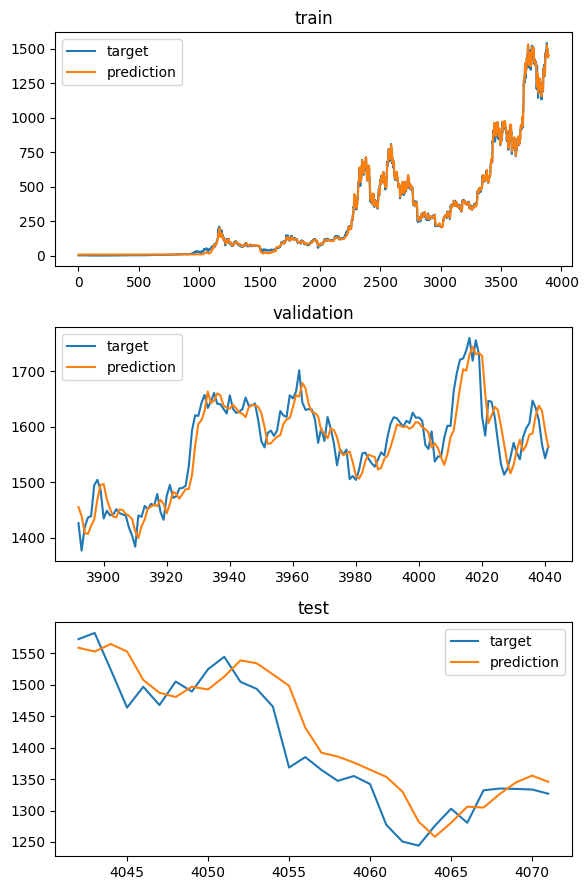

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
Training loss,█▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▂▂▁▁▁▂▁
Training speed (epochs/sec.),▁▇██████████████████████████████████████
Validation loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,4770
Training loss,0.33929
Training speed (epochs/sec.),32.67123
Validation loss,0.16629


In [7]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import argparse
import math

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column="Close", y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def test(test_model, is_reg, max_print=30):
    _, _, test_data_loader = get_btc_krw_data(is_regression=is_reg)

    test_model.eval()
    device = next(test_model.parameters()).device  # 모델이 올라간 디바이스

    print("[TEST DATA]")

    if is_reg:
        mse_sum = 0.0
        mae_sum = 0.0
        n = 0

        printed = 0
        with torch.no_grad():
            for input_test, target_test in test_data_loader:
                input_test = input_test.to(device)
                target_test = target_test.to(device)

                pred = test_model(input_test).squeeze(-1)     # (B,) 또는 (B,1) -> (B,)
                tgt  = target_test.squeeze(-1)

                diff = pred - tgt
                mse_sum += (diff ** 2).sum().item()
                mae_sum += diff.abs().sum().item()
                n += tgt.numel()

                # 원래처럼 몇 개 출력
                if printed < max_print:
                    k = min(max_print - printed, tgt.numel())
                    for i in range(k):
                        print(f"{printed:2}: {pred[i].item():6.2f} <--> {tgt[i].item():6.2f}")
                        printed += 1

        mse = mse_sum / max(n, 1)
        rmse = math.sqrt(mse)
        mae = mae_sum / max(n, 1)
        print(f"TEST RESULTS: RMSE={rmse:7.4f}, MAE={mae:7.4f}, MSE={mse:7.4f}")
        return

    # --- classification ---
    num_correct = 0
    num_total = 0
    printed = 0

    with torch.no_grad():
        for input_test, target_test in test_data_loader:
            input_test = input_test.to(device)
            target_test = target_test.to(device).long()

            logits = test_model(input_test)              # (B, C)
            pred = torch.argmax(logits, dim=1)           # (B,)

            num_correct += (pred == target_test).sum().item()
            num_total += target_test.numel()

            # 원래처럼 몇 개 출력
            if printed < max_print:
                k = min(max_print - printed, target_test.numel())
                for i in range(k):
                    print(f"{printed:2}: {pred[i].item():6.2f} <--> {target_test[i].item():6.2f}")
                    printed += 1

    acc = 100.0 * num_correct / max(num_total, 1)
    print(f"TEST RESULTS: {acc:6.3f}%")

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
    "lstm_layers": args.lstm_layers,
    "dropout_p": args.dropout_p,
    "fc_layers": args.fc_layers,
  }

  project_name = f"lstm_{args.task}_btc_krw_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}"
  run_name = f"{args.task}_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}_{run_time_str}"

  wandb_project = "lstm_classification_btc_krw_hw4"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=wandb_project,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_name,
    config=config
  )
  print(args)
  print(wandb.config)

  is_reg = (args.task == "reg")
  n_output = 1 if is_reg else 2

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(
      sequence_size=21, validation_size=150, test_size=30,
      is_regression=is_reg,
      batch_size=wandb.config.batch_size
  )
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  if is_reg:
    trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  else:
    trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  trainer.train_loop()



  test_model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model, is_reg)
  if is_reg:
    predict_all(test_model)

  wandb.finish()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
        "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
        "-w", "--weight_decay", type=float, default=0.001, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
        "-v", "--validation_intervals", type=int, default=30,
        help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
        "-p", "--early_stop_patience", type=int, default=30,
        help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
        "-d", "--early_stop_delta", type=float, default=0.000001,
        help="Delta value of early stop (float, default: 0.000001)"
    )

    parser.add_argument(
       "--lstm_layers", type=int, default=1
    )

    parser.add_argument(
       "--dropout_p", type=float, default=0.5
    )

    parser.add_argument(
       "--fc_layers", type=int, default=5
    )

    parser.add_argument(
       "--task", choices=["cls", "reg"], default="reg"
    )

    args, _ = parser.parse_known_args([])   # ✅ Jupyter 인자(--f=...) 무시
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


In [8]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import argparse
import math

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column="Close", y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def test(test_model, is_reg, max_print=30):
    _, _, test_data_loader = get_btc_krw_data(is_regression=is_reg)

    test_model.eval()
    device = next(test_model.parameters()).device  # 모델이 올라간 디바이스

    print("[TEST DATA]")

    if is_reg:
        mse_sum = 0.0
        mae_sum = 0.0
        n = 0

        printed = 0
        with torch.no_grad():
            for input_test, target_test in test_data_loader:
                input_test = input_test.to(device)
                target_test = target_test.to(device)

                pred = test_model(input_test).squeeze(-1)     # (B,) 또는 (B,1) -> (B,)
                tgt  = target_test.squeeze(-1)

                diff = pred - tgt
                mse_sum += (diff ** 2).sum().item()
                mae_sum += diff.abs().sum().item()
                n += tgt.numel()

                # 원래처럼 몇 개 출력
                if printed < max_print:
                    k = min(max_print - printed, tgt.numel())
                    for i in range(k):
                        print(f"{printed:2}: {pred[i].item():6.2f} <--> {tgt[i].item():6.2f}")
                        printed += 1

        mse = mse_sum / max(n, 1)
        rmse = math.sqrt(mse)
        mae = mae_sum / max(n, 1)
        print(f"TEST RESULTS: RMSE={rmse:7.4f}, MAE={mae:7.4f}, MSE={mse:7.4f}")
        return

    # --- classification ---
    num_correct = 0
    num_total = 0
    printed = 0

    with torch.no_grad():
        for input_test, target_test in test_data_loader:
            input_test = input_test.to(device)
            target_test = target_test.to(device).long()

            logits = test_model(input_test)              # (B, C)
            pred = torch.argmax(logits, dim=1)           # (B,)

            num_correct += (pred == target_test).sum().item()
            num_total += target_test.numel()

            # 원래처럼 몇 개 출력
            if printed < max_print:
                k = min(max_print - printed, target_test.numel())
                for i in range(k):
                    print(f"{printed:2}: {pred[i].item():6.2f} <--> {target_test[i].item():6.2f}")
                    printed += 1

    acc = 100.0 * num_correct / max(num_total, 1)
    print(f"TEST RESULTS: {acc:6.3f}%")

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
    "lstm_layers": args.lstm_layers,
    "dropout_p": args.dropout_p,
    "fc_layers": args.fc_layers,
  }

  project_name = f"lstm_{args.task}_btc_krw_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}"
  run_name = f"{args.task}_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}_{run_time_str}"

  wandb_project = "lstm_classification_btc_krw_hw4"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=wandb_project,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_name,
    config=config
  )
  print(args)
  print(wandb.config)

  is_reg = (args.task == "reg")
  n_output = 1 if is_reg else 2

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(
      sequence_size=21, validation_size=150, test_size=30,
      is_regression=is_reg,
      batch_size=wandb.config.batch_size
  )
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  if is_reg:
    trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  else:
    trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  trainer.train_loop()



  test_model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model, is_reg)
  if is_reg:
    predict_all(test_model)

  wandb.finish()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
        "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
        "-w", "--weight_decay", type=float, default=0.001, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
        "-v", "--validation_intervals", type=int, default=30,
        help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
        "-p", "--early_stop_patience", type=int, default=30,
        help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
        "-d", "--early_stop_delta", type=float, default=0.000001,
        help="Delta value of early stop (float, default: 0.000001)"
    )

    parser.add_argument(
       "--lstm_layers", type=int, default=2
    )

    parser.add_argument(
       "--dropout_p", type=float, default=0.5
    )

    parser.add_argument(
       "--fc_layers", type=int, default=2
    )

    parser.add_argument(
       "--task", choices=["cls", "reg"], default="cls"
    )

    args, _ = parser.parse_known_args([])   # ✅ Jupyter 인자(--f=...) 무시
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, lstm_layers=2, dropout_p=0.5, fc_layers=2, task='cls')
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'lstm_layers': 2, 'dropout_p': 0.5, 'fc_layers': 2}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69221, T_accuracy: 52.2949 | V_loss: 0.69347, V_accuracy: 50.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69150, T_accuracy: 52.8809 | V_loss: 0.69304, V_accuracy: 50.0000 | V_loss decreased (0.69347 --> 0.69304). Saving model... | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69167, T_accuracy: 52.4902 | V_loss: 0.69288, V_accuracy: 50.0000 | V_loss decreased (0.69304 --> 0.69288). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_l

C:\Users\user\AppData\Local\Temp\ipykernel_30888\3816591543.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map

[TEST DATA]
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   1.00
 5:   0.00 <-->   0.00
 6:   0.00 <-->   1.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   0.00
11:   0.00 <-->   0.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   1.00
15:   0.00 <-->   0.00
16:   0.00 <-->   0.00
17:   0.00 <-->   1.00
18:   0.00 <-->   0.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   0.00
22:   0.00 <-->   1.00
23:   0.00 <-->   1.00
24:   0.00 <-->   0.00
25:   0.00 <-->   1.00
26:   0.00 <-->   1.00
27:   0.00 <-->   0.00
28:   0.00 <-->   0.00
29:   0.00 <-->   0.00
TEST RESULTS: 60.000%


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Training accuracy (%),▃▄▄▂▅▅▅▃▄▃▁▆▅█▄▅▅▂▅▁▄▅▅▁▅▇▇▅▄▃▄▁▃▅▄▄▆▄▅▅
Training loss,▇▅▆▇▄▄▄▅▄▅▇▃▄▁▅▃▄▆▃█▅▅▃▇▃▂▂▅▄▄▆█▆▄▅▅▂▅▅▅
Training speed (epochs/sec.),▁▆█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▁▁▇█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▄▂▂▁▂▁▁▂▂▁▁▁▁▁▂▃▃▁▃▃▃▂▁▂▂▂▃▂▂▂▂▂▂▂▁▃▃▃▄
Epoch,1350
Training accuracy (%),52.00195
Training loss,0.69092
Training speed (epochs/sec.),17.08861
Validation accuracy (%),50


# [문제 2] 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기 (2/2) – Regression 문제 및 Classification 문제에 대해 각각 다른 모델 구성 및 하이퍼파라미터 <br>
값을 찾아 제시– 본인이 찾은 모델 구성 및 하이퍼파라미터 값을 사용하여 다음 테스트 파일의 출력결과 
제시<br>
• _01_code/_18_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py<br>
Ø콘솔 출력 제시 <br>
Ø출력 그래프 제시 (predict_all 함수 수행 결과)<br>
• _01_code/_18_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py<br>
Ø콘솔 출력 제시<br>
• 본 문제에 대한 평가시 전체 학생들의 테스트 결과를 확인하여 더 높은 성능을 제시한 결과에 
더 높은 점수 배정<br>

MODEL FILE: c:\Users\user\git\link_dl\_04_your_code\HW4_2_1_checkpoints\lstm_reg_btc_krw_l1_fc5_do0.5_wd0.001_checkpoint_latest.pt


C:\Users\user\AppData\Local\Temp\ipykernel_30888\274108623.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_

[TEST DATA]
 0: 684.75 <--> 378.60 (Loss:        306.14)
 1: 693.89 <--> 373.05 (Loss:        320.84)
 2: 710.34 <--> 373.07 (Loss:        337.28)
 3: 706.30 <--> 375.84 (Loss:        330.46)
 4: 704.60 <--> 369.19 (Loss:        335.41)
 5: 704.72 <--> 375.70 (Loss:        329.02)
 6: 701.64 <--> 376.00 (Loss:        325.63)
 7: 703.81 <--> 375.55 (Loss:        328.26)
 8: 705.28 <--> 371.69 (Loss:        333.59)
 9: 704.32 <--> 367.74 (Loss:        336.58)
10: 698.03 <--> 359.80 (Loss:        338.23)
11: 687.34 <--> 361.07 (Loss:        326.28)
12: 676.54 <--> 363.47 (Loss:        313.08)
13: 678.17 <--> 363.46 (Loss:        314.72)
14: 678.83 <--> 367.49 (Loss:        311.34)
15: 682.70 <--> 384.49 (Loss:        298.22)
16: 704.23 <--> 384.58 (Loss:        319.65)
17: 719.33 <--> 383.94 (Loss:        335.38)
18: 726.40 <--> 389.72 (Loss:        336.69)
19: 729.04 <--> 400.82 (Loss:        328.22)
20: 742.73 <--> 404.00 (Loss:        338.73)
21: 755.42 <--> 405.02 (Loss:        350.40

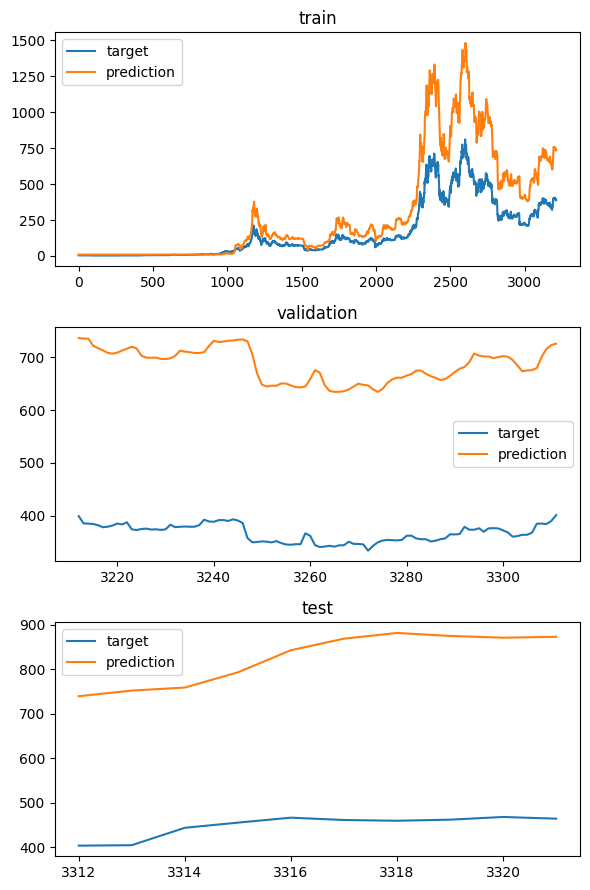

In [9]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl

#BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
#sys.path.append(BASE_PATH)
sys.path.append(str(BASE_PATH))

#CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(get_base_dir())
#CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  #test_model = get_model()
  test_model = get_model(1, 0.5, 5, n_output=1)

  #project_name = "lstm_regression_btc_krw"
  project_name = f"lstm_{"reg"}_btc_krw_l{1}_fc{5}_do{0.5}_wd{0.001}"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  #args = parser.parse_args()
  args, _ = parser.parse_known_args()   # ✅ Jupyter 인자(--f=...) 무시
  main(args)


In [10]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl

#BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
#sys.path.append(BASE_PATH)
sys.path.append(str(BASE_PATH))

#CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CURRENT_FILE_PATH = str(get_base_dir())
#CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")


if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._18_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  #project_name = "lstm_classification_btc_krw"
  project_name = f"lstm_{"cls"}_btc_krw_l{2}_fc{2}_do{0.5}_wd{0.001}"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  #test_model = get_model()
  test_model = get_model(2, 0.5, 2, n_output=2)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  #args = parser.parse_args()
  args, _ = parser.parse_known_args()   # ✅ Jupyter 인자(--f=...) 무시
  main(args)


MODEL FILE: c:\Users\user\git\link_dl\_04_your_code\HW4_2_1_checkpoints\lstm_cls_btc_krw_l2_fc2_do0.5_wd0.001_checkpoint_latest.pt


C:\Users\user\AppData\Local\Temp\ipykernel_30888\441429535.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_l

[TEST DATA]
TEST RESULTS: 70.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   1.00


# [문제 3] 데이터 Feature 추가 후 성능 변화 확인하기 (1/2) – Classification 학습을 위한 데이터 관련 디폴트 설정 값은 문제 2와 동일하게 유지<br>
• sequence_size=21, validation_size=150, test_size=30, is_regression=True– 데이터 Feature에 Next_Open 추가  <br>
• Next_Open: 해당 일자 그 다음 날의 Open 가격<br>

In [11]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
import numpy as np

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(BASE_PATH, "_04_your_code", "BTC_KRW_2025_11_30.csv")
  df = pd.read_csv(btc_krw_path, skiprows=[1])     # ✅ Ticker 메타행 제거
  df = df.rename(columns={'Price': 'Date'})    # ✅ 첫 컬럼이 Date 역할
  df = df[df['Date'] != 'Date'].copy()         # ✅ "Date,,,,," 라벨 행 제거
  df['Date'] = pd.to_datetime(df['Date'])      # ✅ 날짜 파싱

  date_list = df['Date'].copy()
  df = df.drop(columns=['Date'])

  # [문제3] Next_Open 추가: "해당 일자 그 다음 날 Open"
  df['Next_Open'] = df['Open'].shift(-1)

  # 마지막 행은 Next_Open이 NaN이므로 제거 (date_list도 같이 맞추기)
  df = df.iloc[:-1].reset_index(drop=True)
  date_list = date_list.iloc[:-1].reset_index(drop=True)

  row_size = len(df)
  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )
  


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True,
                     target_column="Close", y_normalizer=1.0e7, batch_size=32):

    X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column=target_column,
        y_normalizer=y_normalizer,
        is_regression=is_regression
    )

    train_ds = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    val_ds   = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_ds  = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False, drop_last=False)

    return train_loader, val_loader, test_loader

def get_model(lstm_layers, dropout_p, fc_layers, hidden=256, n_input=6, n_output=2):
  class MyModel(nn.Module):
    def __init__(self):
      super().__init__()
      self.lstm = nn.LSTM(
        input_size=n_input,
        hidden_size=hidden,
        num_layers=lstm_layers,
        dropout=dropout_p if lstm_layers >= 2 else 0.0,
        batch_first=True,
      )

      layers = []
      in_dim = hidden
      for _ in range(fc_layers - 1):
        layers += [nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout_p)]
        in_dim = hidden
      layers += [nn.Linear(in_dim, n_output)]
      self.fcn = nn.Sequential(*layers)

    def forward(self, x):
      x, _ = self.lstm(x)
      x = x[:, -1, :]
      return self.fcn(x)

  return MyModel()


is_regression = True

X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
  = get_cryptocurrency_data(
  sequence_size=21, validation_size=150, test_size=30,
  target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

train_data_loader = DataLoader(
  dataset=train_crypto_currency_dataset,
  batch_size=32,
  shuffle=True,
  drop_last=True
  )

for idx, batch in enumerate(train_data_loader):
  input, target = batch
  print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 21, 6]): torch.Size([32]), tensor([ 8.9948, 14.5827, 12.6413,  8.6020,  3.9010,  0.0665,  7.7067,  0.0272,
         0.7199,  4.3890,  8.3535,  1.2850,  9.5690,  2.2926,  4.3173,  0.7512,
         3.5361,  1.2585,  0.1212,  1.2743,  8.7753,  3.9340, 14.9412,  3.6276,
         8.9335,  0.0292,  0.8860,  0.4783,  0.0331,  0.0541,  0.0333,  5.6534])
1 - torch.Size([32, 21, 6]): torch.Size([32]), tensor([ 0.9881, 14.0555,  0.0938,  6.3621,  0.0909,  5.6819, 14.9245,  0.0662,
         4.9603,  2.7088,  0.0482, 14.9284,  0.0414,  0.7948,  1.4046,  0.6497,
         4.0165,  1.3830,  0.0353, 14.5110,  0.0683,  0.0537,  0.0270,  1.2601,
         0.4061,  8.4204,  1.0195,  1.2655,  1.1685,  8.0697,  3.6489,  0.0480])
2 - torch.Size([32, 21, 6]): torch.Size([32]), tensor([ 1.5192, 12.4710,  0.9915,  0.4033,  0.9542,  2.7743,  0.0451,  0.0488,
         7.7313,  0.0338, 12.1065,  3.8639,  0.0872,  0.7394,  3.9033,  1.0941,
         3.1809,  5.8197,  0.0349,  0.0763,  0.3017,  0.0

# [문제 3] 데이터 Feature 추가 후 성능 변화 확인하기 (2/2) – [문제 2]에서 본인이 찾은 모델 구성 및 하이퍼파라미터 값을 그대로 사용– 데이터 Feature에 Next_Open을 추가하지 않았을 때와 추가하였을 때의 학습 성능 (Train 및 Validation 성능) 비교 및 테스트 (Test) 성능 비교<br>
• Regression 성능과 Classification 성능을 나누어 비교 결과 제시<br>
• 각각의 wandb 내 그래프2개 제시<br>
ØWandb URL #5 (Regression)<br>
» Regression 테스트 성능 비교시에는 predict_all 함수 수행 결과 그래프를 각각 제시<br>
ØWandb URL #6 (Classification)<br>
• 성능 비교 결과에 대해 자신의 해석을 비교적 자세하게 제시<br>

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, lstm_layers=1, dropout_p=0.5, fc_layers=5, task='reg')
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'lstm_layers': 1, 'dropout_p': 0.5, 'fc_layers': 5}
Training on device cuda:0.
[Epoch   1] T_loss: 20.47992, V_loss: 244.34084, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 19.70113, V_loss: 232.62175, V_loss decreased (244.34084 --> 232.62175). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 4.43285, V_loss: 17.64826, V_loss decreased (232.62175 --> 17.64826). Saving model... | T_time: 00:00:02, T_speed: 30.000
[Epoch  90] T_loss: 1.44374, V_loss: 15.91510, V_loss decreased (17.64826 --> 15.91510). Saving model... | T_time: 00:00:02, T_speed:

C:\Users\user\AppData\Local\Temp\ipykernel_30888\593336166.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_

[TEST DATA]
 0:  15.66 <-->  15.65
 1:  15.62 <-->  15.73
 2:  15.58 <-->  15.82
 3:  15.69 <-->  15.24
 4:  15.53 <-->  14.64
 5:  15.07 <-->  14.97
 6:  14.89 <-->  14.68
 7:  14.80 <-->  15.05
 8:  14.96 <-->  14.89
 9:  14.92 <-->  15.25
10:  15.14 <-->  15.44
11:  15.39 <-->  15.05
12:  15.33 <-->  14.93
13:  15.17 <-->  14.65
14:  14.98 <-->  13.68
15:  14.30 <-->  13.85
16:  13.93 <-->  13.65
17:  13.84 <-->  13.47
18:  13.73 <-->  13.55
19:  13.62 <-->  13.42
20:  13.51 <-->  12.77
21:  13.24 <-->  12.51
22:  12.79 <-->  12.44
23:  12.55 <-->  12.76
24:  12.78 <-->  13.03
25:  13.03 <-->  12.80
26:  13.02 <-->  13.32
27:  13.26 <-->  13.35
28:  13.45 <-->  13.34
29:  13.56 <-->  13.33
TEST RESULTS: RMSE= 0.4340, MAE= 0.3417, MSE= 0.1883


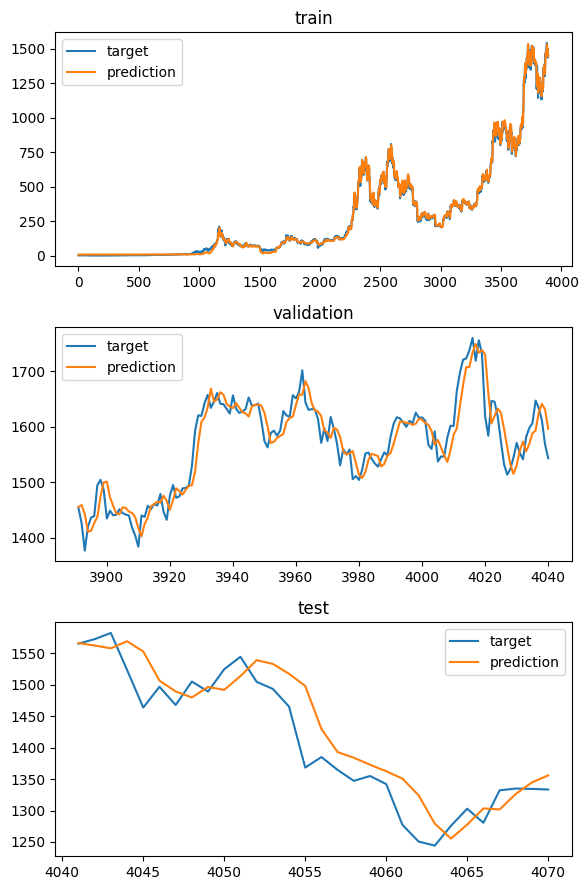

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇█████
Training loss,█▆▇▆▆▆▅▅▃▄▄▃▄▄▅▂▄▄▂▁▂▁▃▃▂▂▃▂▂▂▅▂▃▁▄▃▂▁▁▂
Training speed (epochs/sec.),▁▆█▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3930
Training loss,0.38385
Training speed (epochs/sec.),32.21311
Validation loss,0.37


In [12]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import argparse
import math

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column="Close", y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def test(test_model, is_reg, max_print=30):
    _, _, test_data_loader = get_btc_krw_data(is_regression=is_reg)

    test_model.eval()
    device = next(test_model.parameters()).device  # 모델이 올라간 디바이스

    print("[TEST DATA]")

    if is_reg:
        mse_sum = 0.0
        mae_sum = 0.0
        n = 0

        printed = 0
        with torch.no_grad():
            for input_test, target_test in test_data_loader:
                input_test = input_test.to(device)
                target_test = target_test.to(device)

                pred = test_model(input_test).squeeze(-1)     # (B,) 또는 (B,1) -> (B,)
                tgt  = target_test.squeeze(-1)

                diff = pred - tgt
                mse_sum += (diff ** 2).sum().item()
                mae_sum += diff.abs().sum().item()
                n += tgt.numel()

                # 원래처럼 몇 개 출력
                if printed < max_print:
                    k = min(max_print - printed, tgt.numel())
                    for i in range(k):
                        print(f"{printed:2}: {pred[i].item():6.2f} <--> {tgt[i].item():6.2f}")
                        printed += 1

        mse = mse_sum / max(n, 1)
        rmse = math.sqrt(mse)
        mae = mae_sum / max(n, 1)
        print(f"TEST RESULTS: RMSE={rmse:7.4f}, MAE={mae:7.4f}, MSE={mse:7.4f}")
        return

    # --- classification ---
    num_correct = 0
    num_total = 0
    printed = 0

    with torch.no_grad():
        for input_test, target_test in test_data_loader:
            input_test = input_test.to(device)
            target_test = target_test.to(device).long()

            logits = test_model(input_test)              # (B, C)
            pred = torch.argmax(logits, dim=1)           # (B,)

            num_correct += (pred == target_test).sum().item()
            num_total += target_test.numel()

            # 원래처럼 몇 개 출력
            if printed < max_print:
                k = min(max_print - printed, target_test.numel())
                for i in range(k):
                    print(f"{printed:2}: {pred[i].item():6.2f} <--> {target_test[i].item():6.2f}")
                    printed += 1

    acc = 100.0 * num_correct / max(num_total, 1)
    print(f"TEST RESULTS: {acc:6.3f}%")

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
    "lstm_layers": args.lstm_layers,
    "dropout_p": args.dropout_p,
    "fc_layers": args.fc_layers,
  }

  project_name = f"lstm_{args.task}_btc_krw_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}"
  run_name = f"{args.task}_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}_{run_time_str}"

  wandb_project = "lstm_classification_btc_krw_hw4"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=wandb_project,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_name,
    config=config
  )
  print(args)
  print(wandb.config)

  is_reg = (args.task == "reg")
  n_output = 1 if is_reg else 2

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(
      sequence_size=21, validation_size=150, test_size=30,
      is_regression=is_reg,
      batch_size=wandb.config.batch_size
  )
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  if is_reg:
    trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  else:
    trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  trainer.train_loop()



  test_model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model, is_reg)
  if is_reg:
    predict_all(test_model)

  wandb.finish()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
        "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
        "-w", "--weight_decay", type=float, default=0.001, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
        "-v", "--validation_intervals", type=int, default=30,
        help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
        "-p", "--early_stop_patience", type=int, default=30,
        help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
        "-d", "--early_stop_delta", type=float, default=0.000001,
        help="Delta value of early stop (float, default: 0.000001)"
    )

    parser.add_argument(
       "--lstm_layers", type=int, default=1
    )

    parser.add_argument(
       "--dropout_p", type=float, default=0.5
    )

    parser.add_argument(
       "--fc_layers", type=int, default=5
    )

    parser.add_argument(
       "--task", choices=["cls", "reg"], default="reg"
    )

    args, _ = parser.parse_known_args([])   # ✅ Jupyter 인자(--f=...) 무시
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


In [13]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import argparse
import math

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column="Close", y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def test(test_model, is_reg, max_print=30):
    _, _, test_data_loader = get_btc_krw_data(is_regression=is_reg)

    test_model.eval()
    device = next(test_model.parameters()).device  # 모델이 올라간 디바이스

    print("[TEST DATA]")

    if is_reg:
        mse_sum = 0.0
        mae_sum = 0.0
        n = 0

        printed = 0
        with torch.no_grad():
            for input_test, target_test in test_data_loader:
                input_test = input_test.to(device)
                target_test = target_test.to(device)

                pred = test_model(input_test).squeeze(-1)     # (B,) 또는 (B,1) -> (B,)
                tgt  = target_test.squeeze(-1)

                diff = pred - tgt
                mse_sum += (diff ** 2).sum().item()
                mae_sum += diff.abs().sum().item()
                n += tgt.numel()

                # 원래처럼 몇 개 출력
                if printed < max_print:
                    k = min(max_print - printed, tgt.numel())
                    for i in range(k):
                        print(f"{printed:2}: {pred[i].item():6.2f} <--> {tgt[i].item():6.2f}")
                        printed += 1

        mse = mse_sum / max(n, 1)
        rmse = math.sqrt(mse)
        mae = mae_sum / max(n, 1)
        print(f"TEST RESULTS: RMSE={rmse:7.4f}, MAE={mae:7.4f}, MSE={mse:7.4f}")
        return

    # --- classification ---
    num_correct = 0
    num_total = 0
    printed = 0

    with torch.no_grad():
        for input_test, target_test in test_data_loader:
            input_test = input_test.to(device)
            target_test = target_test.to(device).long()

            logits = test_model(input_test)              # (B, C)
            pred = torch.argmax(logits, dim=1)           # (B,)

            num_correct += (pred == target_test).sum().item()
            num_total += target_test.numel()

            # 원래처럼 몇 개 출력
            if printed < max_print:
                k = min(max_print - printed, target_test.numel())
                for i in range(k):
                    print(f"{printed:2}: {pred[i].item():6.2f} <--> {target_test[i].item():6.2f}")
                    printed += 1

    acc = 100.0 * num_correct / max(num_total, 1)
    print(f"TEST RESULTS: {acc:6.3f}%")

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
    "lstm_layers": args.lstm_layers,
    "dropout_p": args.dropout_p,
    "fc_layers": args.fc_layers,
  }

  project_name = f"lstm_{args.task}_btc_krw_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}"
  run_name = f"{args.task}_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}_{run_time_str}"

  wandb_project = "lstm_classification_btc_krw_hw4"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=wandb_project,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_name,
    config=config
  )
  print(args)
  print(wandb.config)

  is_reg = (args.task == "reg")
  n_output = 1 if is_reg else 2

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(
      sequence_size=21, validation_size=150, test_size=30,
      is_regression=is_reg,
      batch_size=wandb.config.batch_size
  )
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  if is_reg:
    trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  else:
    trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  trainer.train_loop()



  test_model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model, is_reg)
  if is_reg:
    predict_all(test_model)

  wandb.finish()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
        "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
        "-w", "--weight_decay", type=float, default=0.001, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
        "-v", "--validation_intervals", type=int, default=30,
        help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
        "-p", "--early_stop_patience", type=int, default=30,
        help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
        "-d", "--early_stop_delta", type=float, default=0.000001,
        help="Delta value of early stop (float, default: 0.000001)"
    )

    parser.add_argument(
       "--lstm_layers", type=int, default=2
    )

    parser.add_argument(
       "--dropout_p", type=float, default=0.5
    )

    parser.add_argument(
       "--fc_layers", type=int, default=2
    )

    parser.add_argument(
       "--task", choices=["cls", "reg"], default="cls"
    )

    args, _ = parser.parse_known_args([])   # ✅ Jupyter 인자(--f=...) 무시
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, lstm_layers=2, dropout_p=0.5, fc_layers=2, task='cls')
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'lstm_layers': 2, 'dropout_p': 0.5, 'fc_layers': 2}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69499, T_accuracy: 46.5332 | V_loss: 0.69307, V_accuracy: 50.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69182, T_accuracy: 52.3926 | V_loss: 0.69293, V_accuracy: 56.0000 | V_loss decreased (0.69307 --> 0.69293). Saving model... | T_time: 00:00:02, T_speed: 15.000
[Epoch  60] T_loss: 0.69121, T_accuracy: 52.6367 | V_loss: 0.69270, V_accuracy: 50.6667 | V_loss decreased (0.69293 --> 0.69270). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_l

C:\Users\user\AppData\Local\Temp\ipykernel_30888\3816591543.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map

[TEST DATA]
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   1.00
11:   0.00 <-->   0.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   0.00 <-->   1.00
16:   0.00 <-->   0.00
17:   0.00 <-->   0.00
18:   0.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   0.00
22:   0.00 <-->   0.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   1.00
27:   0.00 <-->   1.00
28:   0.00 <-->   0.00
29:   0.00 <-->   0.00
TEST RESULTS: 56.667%


Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▇▇▅▇▇█▇▆█▅▇▇▇▆▆▆▆▅██▇▇█▇▆▇█▇█▆▆▇▇
Training loss,█▄▃▆▃▂▂▃▄▂▆▄▃▂▅▅▄▄▅▁▁▅▂▃▃▄▄▁▂▂▄▃▂▃
Training speed (epochs/sec.),▁▆█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▆▁▁▁▁▁▃▂▂▂▂▂▂▂▂▁▃▃▂▄▃▃▃▃▂▂▃▂▂▂▂▂▃
Epoch,990
Training accuracy (%),52.63672
Training loss,0.69135
Training speed (epochs/sec.),17.06897
Validation accuracy (%),50.66667


문제 3에서는 기존 데이터에 Next_Open(다음 날 Open)을 하나 더 넣어서 학습해봤다. 결과적으로 회귀는 성능이 아주 조금 좋아진 편이었고, 분류는 거의 비슷해서 큰 차이는 없었다.

회귀가 조금 좋아진 건, Next_Open 자체가 가격이랑 꽤 가까운 값이라서 모델 입장에서는 참고할 만한 정보가 하나 더 생긴 거라고 보면 된다. 원래 회귀는 숫자를 정확히 맞춰야 하기 때문이다. 이런 식으로 수치 힌트가 하나 늘면 손실이 조금이라도 내려가는 게 자연스럽다.

반면 분류는 오르냐 내리냐만 맞추는 문제라서, 이미 Open/High/Low/Close 같은 정보만으로도 방향은 어느 정도 판단이 되고, Next_Open을 추가해도 정답이 크게 바뀌지는 않았던 것 같다. 그래서 분류 성능이 크게 달라지지 않은 걸로 보인다.

# [(Optional) 문제 4] 데이터 Feature 추가 + Self-Attention Model 활용– 10점 만점에 추가 점수 3점까지 부여 가능  – [문제 3]에서 제시한 대로 데이터 Feature에 Next_Open을 추가– LSTM 대신에 Self-Attention Model 을 사용하여 학습 성능 (Train 및 Validation 성능) 비교 및 테스트 (Test) 성능 비교<br>
• Regression 성능과 Classification 성능을 나누어 비교 결과 제시<br>
• 각각의 wandb 내 그래프2개 제시<br>
ØWandb URL #7 (Regression)<br>
» Regression 테스트 성능 비교시에는 predict_all 함수 수행 결과 그래프를 각각 제시<br>
ØWandb URL #8 (Classification)<br>
• LSTM vs. Self-Attention 성능 비교 결과 제시<br>
Ø성능 비교 결과에 대해 자신의 해석을 비교적 자세하게 제시<br>

In [14]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
import numpy as np
from torch import nn

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(BASE_PATH, "_04_your_code", "BTC_KRW_2025_11_30.csv")
  df = pd.read_csv(btc_krw_path, skiprows=[1])     # ✅ Ticker 메타행 제거
  df = df.rename(columns={'Price': 'Date'})    # ✅ 첫 컬럼이 Date 역할
  df = df[df['Date'] != 'Date'].copy()         # ✅ "Date,,,,," 라벨 행 제거
  df['Date'] = pd.to_datetime(df['Date'])      # ✅ 날짜 파싱

  date_list = df['Date'].copy()
  df = df.drop(columns=['Date'])

  # [문제3] Next_Open 추가: "해당 일자 그 다음 날 Open"
  df['Next_Open'] = df['Open'].shift(-1)

  # 마지막 행은 Next_Open이 NaN이므로 제거 (date_list도 같이 맞추기)
  df = df.iloc[:-1].reset_index(drop=True)
  date_list = date_list.iloc[:-1].reset_index(drop=True)

  row_size = len(df)
  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )
  


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True,
                     target_column="Close", y_normalizer=1.0e7, batch_size=32):

    X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
        sequence_size=sequence_size,
        validation_size=validation_size,
        test_size=test_size,
        target_column=target_column,
        y_normalizer=y_normalizer,
        is_regression=is_regression
    )

    train_ds = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    val_ds   = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_ds  = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False, drop_last=False)

    return train_loader, val_loader, test_loader

class PositionalEncoding(nn.Module):
    # 너가 올린 예제랑 같은 sinusoidal positional encoding
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        i = torch.arange(0, d_model, 2, dtype=torch.float)
        denom = torch.pow(10000, i / d_model)
        pe[:, 0::2] = torch.sin(pos / denom)
        pe[:, 1::2] = torch.cos(pos / denom)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("position_encoding", pe)

    def forward(self, x):
        # x: (B, T, H)
        return x + self.position_encoding[:, :x.size(1), :]


class EncoderBlock(nn.Module):
    # MultiHeadAttention + FFN 으로 만든 Transformer Encoder block (Pre-LN 스타일)
    def __init__(self, hidden, nhead, dropout_p):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden)
        self.mha = nn.MultiheadAttention(
            embed_dim=hidden,
            num_heads=nhead,
            dropout=dropout_p,
            batch_first=True,
        )
        self.drop1 = nn.Dropout(dropout_p)

        self.ln2 = nn.LayerNorm(hidden)
        self.ffn = nn.Sequential(
            nn.Linear(hidden, hidden * 4),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden * 4, hidden),
            nn.Dropout(dropout_p),
        )

    def forward(self, x, key_padding_mask=None):
        # x: (B, T, H)
        # --- Self-Attention (Pre-LN) ---
        h = self.ln1(x)
        attn_out, _ = self.mha(
            h, h, h,
            key_padding_mask=key_padding_mask,  # 고정길이면 None으로 둬도 OK
            need_weights=False
        )
        x = x + self.drop1(attn_out)

        # --- FFN (Pre-LN) ---
        h = self.ln2(x)
        x = x + self.ffn(h)
        return x


def get_model(lstm_layers, dropout_p, fc_layers, hidden=256, n_input=6, n_output=2):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            # head 수는 hidden이 나누어 떨어져야 함
            nhead = 8
            if hidden % nhead != 0:
                for h in (8, 2, 1):
                    if hidden % h == 0:
                        nhead = h
                        break

            # 입력 feature -> hidden
            self.in_proj = nn.Linear(n_input, hidden)
            self.in_ln = nn.LayerNorm(hidden)
            self.in_drop = nn.Dropout(dropout_p)

            # Positional Encoding
            self.pos_enc = PositionalEncoding(hidden, max_len=5000)

            # Encoder blocks
            self.blocks = nn.ModuleList([
                EncoderBlock(hidden=hidden, nhead=nhead, dropout_p=dropout_p)
                for _ in range(lstm_layers)
            ])

            self.out_ln = nn.LayerNorm(hidden)

            # FC head
            layers = []
            in_dim = hidden
            for _ in range(fc_layers - 1):
                layers += [nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout_p)]
                in_dim = hidden
            layers += [nn.Linear(in_dim, n_output)]
            self.fcn = nn.Sequential(*layers)

        def forward(self, x):
            # x: (B, T, F)
            h = self.in_proj(x)                  # (B,T,H)
            h = self.in_drop(self.in_ln(h))

            # Positional Encoding (길이 T 그대로)
            h = self.pos_enc(h)                  # (B,T,H)

            # Encoder stack
            for blk in self.blocks:
                h = blk(h, key_padding_mask=None)

            h = self.out_ln(h)

            # 마지막 토큰(가장 최근 day)로 예측
            #feat = h[:, -1, :]                   # (B,H)
            feat = h.mean(dim=1) # 전체 평균
            out = self.fcn(feat)                 # (B,n_output)

            # 회귀(n_output=1)면 (B,)로
            if out.size(-1) == 1:
                out = out.squeeze(-1)
            return out

    return MyModel()


is_regression = True

X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
  = get_cryptocurrency_data(
  sequence_size=21, validation_size=150, test_size=30,
  target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

train_data_loader = DataLoader(
  dataset=train_crypto_currency_dataset,
  batch_size=32,
  shuffle=True,
  drop_last=True
  )

for idx, batch in enumerate(train_data_loader):
  input, target = batch
  print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 21, 6]): torch.Size([32]), tensor([ 1.3927,  3.8912,  5.2126,  0.9694,  0.6834,  1.7506,  0.0458,  0.0506,
         1.2405,  6.8867,  4.2333,  3.2017,  1.3911, 14.5806,  1.4085,  1.4407,
         0.0291,  0.4247,  2.5693,  0.7788,  0.0273,  1.3907,  6.8755,  6.3300,
         9.2544,  0.2812,  2.2273,  0.5002,  1.2499,  0.7230,  4.3445, 13.7728])
1 - torch.Size([32, 21, 6]): torch.Size([32]), tensor([ 0.6927,  0.4053, 13.0260,  3.6176,  0.8963,  0.4780,  0.0420,  7.5953,
         0.9529,  2.7889,  0.0426, 13.6201,  0.3850,  0.5482,  5.7900,  2.7627,
         0.9921,  4.0832,  9.6990,  0.8342,  3.9886,  6.6385,  0.7325,  0.4460,
         3.5896,  0.7118,  2.8997,  1.2676,  0.0476,  0.0280,  5.7564,  1.2708])
2 - torch.Size([32, 21, 6]): torch.Size([32]), tensor([ 1.1104,  0.0279,  0.9848,  0.1051,  7.1231, 14.3911, 14.5692,  7.9235,
         3.8153,  2.1963,  8.3353,  0.7239,  3.7117,  4.6815,  2.7110,  5.6193,
         0.7199,  7.2481,  5.7498,  0.0801,  5.9671,  1.0

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, lstm_layers=1, dropout_p=0.5, fc_layers=5, task='reg')
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'lstm_layers': 1, 'dropout_p': 0.5, 'fc_layers': 5}
Training on device cuda:0.
[Epoch   1] T_loss: 19.95096, V_loss: 243.75427, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 12.65380, V_loss: 177.36143, V_loss decreased (243.75427 --> 177.36143). Saving model... | T_time: 00:00:03, T_speed: 10.000
[Epoch  60] T_loss: 3.44382, V_loss: 58.19077, V_loss decreased (177.36143 --> 58.19077). Saving model... | T_time: 00:00:07, T_speed: 8.571
[Epoch  90] T_loss: 1.72686, V_loss: 7.39317, V_loss decreased (58.19077 --> 7.39317). Saving model... | T_time: 00:00:10, T_speed: 9.

C:\Users\user\AppData\Local\Temp\ipykernel_30888\616736977.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_

[TEST DATA]
 0:  16.47 <-->  15.65
 1:  16.44 <-->  15.73
 2:  16.32 <-->  15.82
 3:  16.23 <-->  15.24
 4:  16.20 <-->  14.64
 5:  16.27 <-->  14.97
 6:  16.29 <-->  14.68
 7:  16.27 <-->  15.05
 8:  16.30 <-->  14.89
 9:  16.28 <-->  15.25
10:  16.25 <-->  15.44
11:  16.26 <-->  15.05
12:  16.25 <-->  14.93
13:  16.22 <-->  14.65
14:  16.27 <-->  13.68
15:  16.32 <-->  13.85
16:  16.21 <-->  13.65
17:  16.11 <-->  13.47
18:  16.06 <-->  13.55
19:  16.05 <-->  13.42
20:  16.00 <-->  12.77
21:  15.96 <-->  12.51
22:  16.00 <-->  12.44
23:  15.79 <-->  12.76
24:  15.60 <-->  13.03
25:  15.45 <-->  12.80
26:  15.30 <-->  13.32
27:  15.19 <-->  13.35
28:  15.10 <-->  13.34
29:  14.98 <-->  13.33
TEST RESULTS: RMSE= 2.0862, MAE= 1.9067, MSE= 4.3523


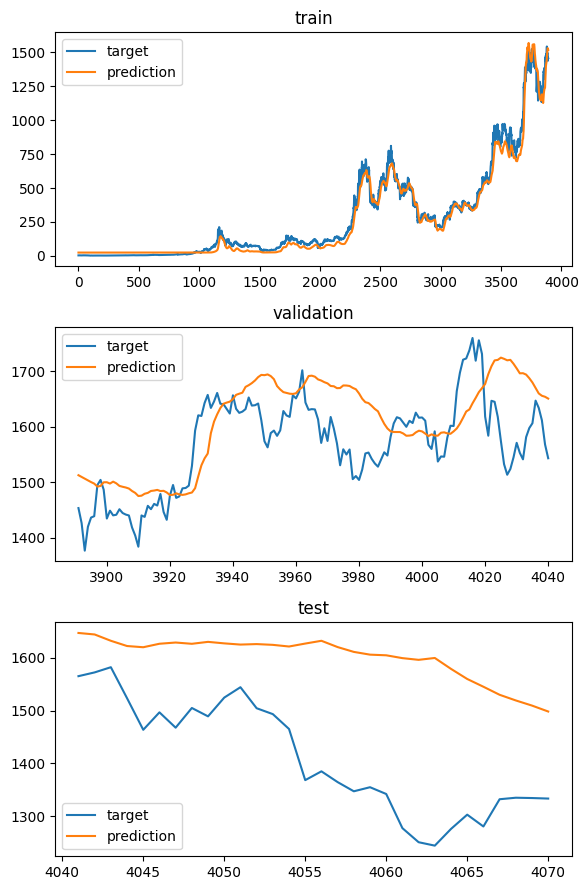

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1050
Training loss,0.57338
Training speed (epochs/sec.),8.60656
Validation loss,3.6099


In [15]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import argparse
import math

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column="Close", y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def test(test_model, is_reg, max_print=30):
    _, _, test_data_loader = get_btc_krw_data(is_regression=is_reg)

    test_model.eval()
    device = next(test_model.parameters()).device  # 모델이 올라간 디바이스

    print("[TEST DATA]")

    if is_reg:
        mse_sum = 0.0
        mae_sum = 0.0
        n = 0

        printed = 0
        with torch.no_grad():
            for input_test, target_test in test_data_loader:
                input_test = input_test.to(device)
                target_test = target_test.to(device)

                pred = test_model(input_test).squeeze(-1)     # (B,) 또는 (B,1) -> (B,)
                tgt  = target_test.squeeze(-1)

                diff = pred - tgt
                mse_sum += (diff ** 2).sum().item()
                mae_sum += diff.abs().sum().item()
                n += tgt.numel()

                # 원래처럼 몇 개 출력
                if printed < max_print:
                    k = min(max_print - printed, tgt.numel())
                    for i in range(k):
                        print(f"{printed:2}: {pred[i].item():6.2f} <--> {tgt[i].item():6.2f}")
                        printed += 1

        mse = mse_sum / max(n, 1)
        rmse = math.sqrt(mse)
        mae = mae_sum / max(n, 1)
        print(f"TEST RESULTS: RMSE={rmse:7.4f}, MAE={mae:7.4f}, MSE={mse:7.4f}")
        return

    # --- classification ---
    num_correct = 0
    num_total = 0
    printed = 0

    with torch.no_grad():
        for input_test, target_test in test_data_loader:
            input_test = input_test.to(device)
            target_test = target_test.to(device).long()

            logits = test_model(input_test)              # (B, C)
            pred = torch.argmax(logits, dim=1)           # (B,)

            num_correct += (pred == target_test).sum().item()
            num_total += target_test.numel()

            # 원래처럼 몇 개 출력
            if printed < max_print:
                k = min(max_print - printed, target_test.numel())
                for i in range(k):
                    print(f"{printed:2}: {pred[i].item():6.2f} <--> {target_test[i].item():6.2f}")
                    printed += 1

    acc = 100.0 * num_correct / max(num_total, 1)
    print(f"TEST RESULTS: {acc:6.3f}%")

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
    "lstm_layers": args.lstm_layers,
    "dropout_p": args.dropout_p,
    "fc_layers": args.fc_layers,
  }

  project_name = f"sa_{args.task}_btc_krw_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}"
  run_name = f"{args.task}_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}_{run_time_str}"

  wandb_project = "sa_classification_btc_krw_hw4"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=wandb_project,
    notes="btc_krw experiment with lstm",
    tags=["sa", "classification", "btc_krw"],
    name=run_name,
    config=config
  )
  print(args)
  print(wandb.config)

  is_reg = (args.task == "reg")
  n_output = 1 if is_reg else 2

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(
      sequence_size=21, validation_size=150, test_size=30,
      is_regression=is_reg,
      batch_size=wandb.config.batch_size
  )
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  if is_reg:
    trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  else:
    trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  trainer.train_loop()



  test_model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model, is_reg)
  if is_reg:
    predict_all(test_model)

  wandb.finish()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
        "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
        "-w", "--weight_decay", type=float, default=0.001, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
        "-v", "--validation_intervals", type=int, default=30,
        help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
        "-p", "--early_stop_patience", type=int, default=30,
        help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
        "-d", "--early_stop_delta", type=float, default=0.000001,
        help="Delta value of early stop (float, default: 0.000001)"
    )

    parser.add_argument(
       "--lstm_layers", type=int, default=1
    )

    parser.add_argument(
       "--dropout_p", type=float, default=0.5
    )

    parser.add_argument(
       "--fc_layers", type=int, default=5
    )

    parser.add_argument(
       "--task", choices=["cls", "reg"], default="reg"
    )

    args, _ = parser.parse_known_args([])   # ✅ Jupyter 인자(--f=...) 무시
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


In [16]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import argparse
import math

def get_base_dir():
    try:
        return Path(__file__).resolve()  # .py 스크립트/모듈일 때
    except NameError:
        return Path.cwd()                # 노트북/인터랙티브일 때

BASE_PATH = get_base_dir().parent  # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(str(BASE_PATH))

CURRENT_FILE_PATH = str(get_base_dir())
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "HW4_2_1_checkpoints"))

from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, *_ = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column="Close", y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def test(test_model, is_reg, max_print=30):
    _, _, test_data_loader = get_btc_krw_data(is_regression=is_reg)

    test_model.eval()
    device = next(test_model.parameters()).device  # 모델이 올라간 디바이스

    print("[TEST DATA]")

    if is_reg:
        mse_sum = 0.0
        mae_sum = 0.0
        n = 0

        printed = 0
        with torch.no_grad():
            for input_test, target_test in test_data_loader:
                input_test = input_test.to(device)
                target_test = target_test.to(device)

                pred = test_model(input_test).squeeze(-1)     # (B,) 또는 (B,1) -> (B,)
                tgt  = target_test.squeeze(-1)

                diff = pred - tgt
                mse_sum += (diff ** 2).sum().item()
                mae_sum += diff.abs().sum().item()
                n += tgt.numel()

                # 원래처럼 몇 개 출력
                if printed < max_print:
                    k = min(max_print - printed, tgt.numel())
                    for i in range(k):
                        print(f"{printed:2}: {pred[i].item():6.2f} <--> {tgt[i].item():6.2f}")
                        printed += 1

        mse = mse_sum / max(n, 1)
        rmse = math.sqrt(mse)
        mae = mae_sum / max(n, 1)
        print(f"TEST RESULTS: RMSE={rmse:7.4f}, MAE={mae:7.4f}, MSE={mse:7.4f}")
        return

    # --- classification ---
    num_correct = 0
    num_total = 0
    printed = 0

    with torch.no_grad():
        for input_test, target_test in test_data_loader:
            input_test = input_test.to(device)
            target_test = target_test.to(device).long()

            logits = test_model(input_test)              # (B, C)
            pred = torch.argmax(logits, dim=1)           # (B,)

            num_correct += (pred == target_test).sum().item()
            num_total += target_test.numel()

            # 원래처럼 몇 개 출력
            if printed < max_print:
                k = min(max_print - printed, target_test.numel())
                for i in range(k):
                    print(f"{printed:2}: {pred[i].item():6.2f} <--> {target_test[i].item():6.2f}")
                    printed += 1

    acc = 100.0 * num_correct / max(num_total, 1)
    print(f"TEST RESULTS: {acc:6.3f}%")

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
    "lstm_layers": args.lstm_layers,
    "dropout_p": args.dropout_p,
    "fc_layers": args.fc_layers,
  }

  project_name = f"sa_{args.task}_btc_krw_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}"
  run_name = f"{args.task}_l{args.lstm_layers}_fc{args.fc_layers}_do{args.dropout_p}_wd{args.weight_decay}_{run_time_str}"

  wandb_project = "sa_classification_btc_krw_hw4"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=wandb_project,
    notes="btc_krw experiment with lstm",
    tags=["sa", "classification", "btc_krw"],
    name=run_name,
    config=config
  )
  print(args)
  print(wandb.config)

  is_reg = (args.task == "reg")
  n_output = 1 if is_reg else 2

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(
      sequence_size=21, validation_size=150, test_size=30,
      is_regression=is_reg,
      batch_size=wandb.config.batch_size
  )
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  if is_reg:
    trainer = RegressionTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  else:
    trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
  trainer.train_loop()



  test_model = get_model(args.lstm_layers, args.dropout_p, args.fc_layers, n_output=n_output)

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model, is_reg)
  if is_reg:
    predict_all(test_model)

  wandb.finish()


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
    )

    parser.add_argument(
        "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
        "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
        "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
        "-w", "--weight_decay", type=float, default=0.001, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
        "-v", "--validation_intervals", type=int, default=30,
        help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
        "-p", "--early_stop_patience", type=int, default=30,
        help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
        "-d", "--early_stop_delta", type=float, default=0.000001,
        help="Delta value of early stop (float, default: 0.000001)"
    )

    parser.add_argument(
       "--lstm_layers", type=int, default=2
    )

    parser.add_argument(
       "--dropout_p", type=float, default=0.5
    )

    parser.add_argument(
       "--fc_layers", type=int, default=2
    )

    parser.add_argument(
       "--task", choices=["cls", "reg"], default="cls"
    )

    args, _ = parser.parse_known_args([])   # ✅ Jupyter 인자(--f=...) 무시
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.001, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06, lstm_layers=2, dropout_p=0.5, fc_layers=2, task='cls')
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.001, 'lstm_layers': 2, 'dropout_p': 0.5, 'fc_layers': 2}
Training on device cuda:0.
[Epoch   1] T_loss: 0.70205, T_accuracy: 49.8535 | V_loss: 0.69381, V_accuracy: 49.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69397, T_accuracy: 51.5625 | V_loss: 0.69389, V_accuracy: 50.6667 | Early stopping counter: 1 out of 30 | T_time: 00:00:06, T_speed: 5.000
[Epoch  60] T_loss: 0.69080, T_accuracy: 52.8320 | V_loss: 0.69334, V_accuracy: 49.3333 | V_loss decreased (0.69381 --> 0.69334). Saving model... | T_time: 00:00:13, T_speed: 4.615
[Epoch  90] T_loss: 0.69069, T_accura

C:\Users\user\AppData\Local\Temp\ipykernel_30888\66468685.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_l

[TEST DATA]
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   1.00
11:   0.00 <-->   0.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   0.00 <-->   1.00
16:   0.00 <-->   0.00
17:   0.00 <-->   0.00
18:   0.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   0.00
22:   0.00 <-->   0.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   1.00
27:   0.00 <-->   1.00
28:   0.00 <-->   0.00
29:   0.00 <-->   0.00
TEST RESULTS: 56.667%


Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▃▅▆▃█▅▅▅▄▆▅▂▄▄▄▅▆▅▆▅▆▄▅▅▅▅▅▆▅▇▄▆▃▅▅▅
Training loss,█▄▂▂▃▁▂▂▂▃▂▃▃▃▂▂▃▂▃▁▂▃▃▂▂▃▁▂▂▂▁▃▂▃▃▂▂
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▃▅▃▅█▃▅▃▃▅▅▆▅▁▅▁▅▃▅▅▅▅▅▅▅▃▁▅▅▄▅▅▅▅▅▅▅
Validation loss,▄▄▂▃▁▇▁▄█▂▄▃▂▂▂▂▂▅▄▂▃▂▂▂▃▃▂▃▃▂▂▂▂▂▂▄▂
Epoch,1080
Training accuracy (%),53.07617
Training loss,0.69015
Training speed (epochs/sec.),4.55696
Validation accuracy (%),50.66667


문제 4에서는 Next_Open까지 포함한 상태에서, LSTM 대신 Self-Attention 모델로 바꿔서 비교했다. 여기서는 회귀 성능이 오히려 LSTM보다 나빠졌고, 분류는 둘 다 비슷해서 차이가 거의 없었다.

회귀가 나빠진 건, 어텐션 모델이 가격을 딱 붙어서 따라가는 쪽보다는 중간쯤 안전한 값으로 예측하는 쪽으로 가버린 영향이 큰 것 같다. 변동성이 큰 시계열에서 모델이 패턴을 확실히 못 잡으면, MSE 기준으로는 평균 근처를 내는 게 손해가 덜하니까 그런 쪽으로 수렴하는 경우가 있다. LSTM은 구조적으로 시간이 흐르는 방향으로 정보를 쌓는 방식이라 최근 며칠이 중요하다 같은 시계열 특성을 좀 더 자연스럽게 먹는 반면, 어텐션은 전체를 한 번에 섞어서 보니까 설정이 조금만 안 맞아도 회귀에서 이런 현상이 더 잘 나오는 것 같다.

여기서 포지셔널 인코딩도 영향을 줬을 수 있다. 어텐션은 기본적으로 순서 정보가 없기 때문에, 포지셔널 인코딩이 제대로 들어가야 모델이 21일이라는 시간 순서를 감지한다. 그런데 코인 가격처럼 절대값 스케일이 크고 변동성이 큰 데이터에서는, 포지셔널 인코딩이 입력 특징들에 비해 상대적으로 약하게 섞이거나 반대로 너무 크게 섞여서 학습을 방해하는 경우도 있다. 특히 sinusoidal 방식은 고정된 패턴이라 데이터에 최적화되어 조정되는 게 아니어서, LSTM처럼 순서가 구조로 박혀 있는 모델보다 시간 정보 활용이 덜 안정적으로 나올 수 있다. 그 결과 어텐션이 최근 정보를 강하게 반영하지 못하고 평균적인 예측으로 가는 데 한몫했을 가능성이 있다.

분류는 어차피 방향만 맞추면 되는 문제라서, 회귀처럼 숫자를 촘촘하게 맞출 필요가 없다. 그래서 모델을 바꿔도 성능이 비슷하게 나온 걸로 보인다. 결국 이번 조건에서는 회귀는 LSTM이 더 안정적이고, 분류는 둘 다 큰 차이가 없다 정도로 정리할 수 있을 것 같다.

# 숙제후기

비트코인이라는 시계열 데이터를 예측하는 것을 수행하는 과정은 재미있었다.

그리고 예측하기 어려울 수록 검증 데이터의 로스가 단지 감소하지만은 않는다는 것을 알 수 있었다.

모델을 약간만 바꿔도 검증 로스가 발산하는 형태를 보여서 예측이 어려운 데이터는 모델의 구조가 중요함을 느꼈다.

그리고 시계열 데이터는 보통 fc를 많이 쓰면 분류가 잘되는 경향이 있었던 것 같다. LSTM은 레이어가 많다고 좋은 것은 아닌걸까?

만능 근사머신 FC의 힘을 느끼게 된다.

LSTM과 동일한 조건으로 셀프어텐션을 대체했더니 썩 좋지 않은 결과가 나왔다.

어텐션이 더 좋을 줄 알았는데 많이 아쉬웠다.